In [1]:
!pip install -r requirements.txt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import gzip
import torch
from IPython.display import display

from json import loads
from tqdm.notebook import tqdm
from typing import Iterable, Union, TypeVar
from scipy import sparse
from sklearn.model_selection import train_test_split


tqdm.pandas()

2021-12-08 19:30:00.463223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 19:30:00.463238: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data loading

In [3]:
def parse_json(filename: str, read_max: int = None, attributes: Iterable[str] = None) -> pd.DataFrame:
    """
    Reads the file line by line, parsing each line as json.

    :param filename: The path to the datafile.
    :param read_max: The maximum number of lines to read from the datafile.
    :param attributes: The attributes of each JSON object that should be extracted; other attributes are ignored.
    """
    file = gzip.open(filename, "r")
    data = []
    for index, line in enumerate(tqdm(file)):
        if index == read_max:
            break
        entry = loads(line)
        if attributes is not None:
            entry = {key: entry[key] for key in attributes}
        data.append(entry)
    return pd.DataFrame.from_dict(data)

In [4]:
data_path = "data/"
books = f"{data_path}goodreads_books_comics_graphic.json.gz"
interactions = f"{data_path}goodreads_interactions_comics_graphic.json.gz"
reviews = f"{data_path}goodreads_reviews_comics_graphic.json.gz"

n = 500000

books_df = parse_json(books, n, ("book_id", "title"))
interactions_df = parse_json(interactions, n, ("user_id", "book_id", "rating", "date_updated"))

display(books_df.head(10))
display(interactions_df.head(10))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,book_id,title
0,25742454,The Switchblade Mamma
1,30128855,Cruelle
2,13571772,Captain America: Winter Soldier (The Ultimate ...
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...
4,707611,"Superman Archives, Vol. 2"
5,2250580,"A.I. Revolution, Vol. 1"
6,27036536,"War Stories, Volume 3"
7,27036537,"Crossed, Volume 15"
8,27036538,"Crossed + One Hundred, Volume 2 (Crossed +100 #2)"
9,27036539,"War Stories, Volume 4"


,user_id,book_id,rating,date_updated
0,8842281e1d1347389f2ab93d60773d4d,836610,0,Mon Aug 21 12:11:00 -0700 2017
1,8842281e1d1347389f2ab93d60773d4d,7648967,0,Fri Feb 24 08:59:44 -0800 2017
2,8842281e1d1347389f2ab93d60773d4d,15704307,0,Wed May 20 21:28:57 -0700 2015
3,8842281e1d1347389f2ab93d60773d4d,6902644,0,Sun Jun 01 17:25:23 -0700 2014
4,8842281e1d1347389f2ab93d60773d4d,9844623,0,Sun Sep 02 08:45:08 -0700 2012
5,8842281e1d1347389f2ab93d60773d4d,13163846,0,Tue Jul 24 14:36:13 -0700 2012
6,8842281e1d1347389f2ab93d60773d4d,1137635,0,Fri Mar 26 08:58:33 -0700 2010
7,8842281e1d1347389f2ab93d60773d4d,44735,0,Fri Jun 05 12:28:44 -0700 2009
8,8842281e1d1347389f2ab93d60773d4d,472331,0,Fri Jun 05 12:28:47 -0700 2009
9,8842281e1d1347389f2ab93d60773d4d,24815,5,Thu Apr 17 23:42:49 -0700 2008


In [5]:
# Convert the columns to the correct types
interactions_df["date_updated"] = pd.to_datetime(interactions_df["date_updated"], format="%a %b %d %H:%M:%S %z %Y")
books_df["book_id"] = books_df["book_id"].astype("int64")
interactions_df["book_id"] = interactions_df["book_id"].astype("int64")

# Sort the interactions by user ID and the timestamp
interactions_df = interactions_df.sort_values(by=["user_id", "date_updated"], ascending=[True, True])

# Preprocessing

In [6]:
def preprocess(dataframe: pd.DataFrame, min_support: int = 5) -> pd.DataFrame:
    """
    Removes users with fewer than `min_support` interactions, and duplicate user-item pairs (which do not exist in the
    dataset anyway). Items with very few interactions are not removed, unless they have no interactions at all after
    removing infrequent users.
    """
    print(dataframe.shape[0], "initial rows")
    # Drop reconsumption items
    dataframe = dataframe.drop_duplicates(subset=["user_id", "book_id"])
    # Drop users with less than `min_support` interactions
    items_per_user = dataframe.groupby("user_id", as_index=False)["book_id"].size()
    items_per_user = items_per_user.rename({"size": "items_per_user"}, axis="columns")
    dataframe = pd.merge(dataframe, items_per_user, how="left", on=["user_id"])
    dataframe = dataframe[dataframe["items_per_user"] >= min_support]
    # Report and clean up after the preprocessing
    print(dataframe.shape[0], "rows after preprocessing")
    dataframe.drop(columns=["items_per_user"], inplace=True)
    return dataframe


display(interactions_df.head(10))
print(f"Number of unique users:", interactions_df["user_id"].nunique())
print(f"Number of unique items:", interactions_df["book_id"].nunique())
interactions_df = preprocess(interactions_df, min_support=5)
print(f"Number of unique users:", interactions_df["user_id"].nunique())
print(f"Number of unique items:", interactions_df["book_id"].nunique())
display(interactions_df.head(10))

,user_id,book_id,rating,date_updated
496200,00153d136ac254437511fad5e10e246d,7619292,3,2012-08-30 11:53:39-07:00
496199,00153d136ac254437511fad5e10e246d,29396738,0,2017-08-07 03:40:09-07:00
350064,0018ce6296baeccf95c3502deeff0600,472331,5,2012-08-05 09:26:00-07:00
350062,0018ce6296baeccf95c3502deeff0600,3058907,4,2012-08-05 13:11:48-07:00
350061,0018ce6296baeccf95c3502deeff0600,4280231,4,2012-08-05 13:11:52-07:00
350059,0018ce6296baeccf95c3502deeff0600,11470711,5,2012-08-05 13:14:57-07:00
350058,0018ce6296baeccf95c3502deeff0600,844355,4,2012-08-05 13:19:32-07:00
350057,0018ce6296baeccf95c3502deeff0600,1568491,4,2012-08-05 13:19:39-07:00
350056,0018ce6296baeccf95c3502deeff0600,23754,4,2012-08-09 03:53:26-07:00
350063,0018ce6296baeccf95c3502deeff0600,13480845,5,2012-08-15 04:26:40-07:00


Number of unique users: 18246
Number of unique items: 53635
500000 initial rows
482272 rows after preprocessing
Number of unique users: 8931
Number of unique items: 53210


,user_id,book_id,rating,date_updated
2,0018ce6296baeccf95c3502deeff0600,472331,5,2012-08-05 09:26:00-07:00
3,0018ce6296baeccf95c3502deeff0600,3058907,4,2012-08-05 13:11:48-07:00
4,0018ce6296baeccf95c3502deeff0600,4280231,4,2012-08-05 13:11:52-07:00
5,0018ce6296baeccf95c3502deeff0600,11470711,5,2012-08-05 13:14:57-07:00
6,0018ce6296baeccf95c3502deeff0600,844355,4,2012-08-05 13:19:32-07:00
7,0018ce6296baeccf95c3502deeff0600,1568491,4,2012-08-05 13:19:39-07:00
8,0018ce6296baeccf95c3502deeff0600,23754,4,2012-08-09 03:53:26-07:00
9,0018ce6296baeccf95c3502deeff0600,13480845,5,2012-08-15 04:26:40-07:00
10,0018ce6296baeccf95c3502deeff0600,3887304,5,2012-10-10 03:59:19-07:00
11,0018ce6296baeccf95c3502deeff0600,12079555,3,2015-02-07 04:25:49-08:00


In [7]:
def apply_consecutive_mapping(dataframe: pd.DataFrame, column: str, new_column: str, *additional: pd.DataFrame) -> None:
    """
    Generates a consecutive ID column for the values of an existing column. Also adds this column to additional data
    frames with the exact same mapping of old ID to new (consecutive) ID.
    """
    ids = {}

    def map_to_consecutive_ids(uuid: Union[int, np.int64]) -> int:
        """
        To be used with `pd.Dataframe.apply()` or `pd.Dataframe.progress_apply()`; returns a unique ID per distinct
        value.
        """
        if uuid not in ids:
            ids[uuid] = len(ids)
        return ids[uuid]

    dataframe[new_column] = dataframe[column].progress_apply(map_to_consecutive_ids)
    for frame in additional:
        frame[new_column] = frame[column].progress_apply(lambda old_id: ids.get(old_id, -1))


apply_consecutive_mapping(interactions_df, "user_id", "user_id_int")
apply_consecutive_mapping(interactions_df, "book_id", "book_id_int", books_df)

interactions_df = interactions_df[["user_id_int", "book_id_int", "date_updated", "rating"]]
interactions_df = interactions_df.rename(
    columns={"user_id_int": "user_id", "book_id_int": "item_id", "date_updated": "datetime"})

display(books_df.head(10))
display(interactions_df.head(10))

  0%|          | 0/482272 [00:00<?, ?it/s]

  0%|          | 0/482272 [00:00<?, ?it/s]

  0%|          | 0/89411 [00:00<?, ?it/s]

,book_id,title,book_id_int
0,25742454,The Switchblade Mamma,-1
1,30128855,Cruelle,15002
2,13571772,Captain America: Winter Soldier (The Ultimate ...,43185
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...,-1
4,707611,"Superman Archives, Vol. 2",-1
5,2250580,"A.I. Revolution, Vol. 1",11921
6,27036536,"War Stories, Volume 3",46912
7,27036537,"Crossed, Volume 15",46927
8,27036538,"Crossed + One Hundred, Volume 2 (Crossed +100 #2)",46931
9,27036539,"War Stories, Volume 4",13789


,user_id,item_id,datetime,rating
2,0,0,2012-08-05 09:26:00-07:00,5
3,0,1,2012-08-05 13:11:48-07:00,4
4,0,2,2012-08-05 13:11:52-07:00,4
5,0,3,2012-08-05 13:14:57-07:00,5
6,0,4,2012-08-05 13:19:32-07:00,4
7,0,5,2012-08-05 13:19:39-07:00,4
8,0,6,2012-08-09 03:53:26-07:00,4
9,0,7,2012-08-15 04:26:40-07:00,5
10,0,8,2012-10-10 03:59:19-07:00,5
11,0,9,2015-02-07 04:25:49-08:00,3


In [8]:
DataType = TypeVar("DataType", pd.DataFrame, sparse.csr_matrix)

def generate_random_split(data: DataType, seed: int = None) -> tuple[DataType, DataType]:
    return train_test_split(data, test_size=0.2, random_state=seed)


def create_sparse_matrix(dataframe: pd.DataFrame, shape: tuple[int, int] = None) -> sparse.csr_matrix:
    return sparse.csr_matrix((dataframe["rating"], (dataframe["user_id"], dataframe["item_id"])), shape=shape,
                             dtype=np.int8)

def convert_sparse_matrix_to_sparse_tensor(X) -> tf.SparseTensor:
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, np.float32(coo.data), coo.shape)



In [9]:
shape = (interactions_df["user_id"].max() + 1, interactions_df["item_id"].max() + 1)
interaction_matrix = create_sparse_matrix(interactions_df,shape)
normalized_matrix = interaction_matrix
normalized_matrix.data = (interaction_matrix.data/5.0)
train, test = generate_random_split(normalized_matrix, seed=1)


In [10]:
tensor_train = convert_sparse_matrix_to_sparse_tensor(train)
tensor_test = convert_sparse_matrix_to_sparse_tensor(test)

2021-12-08 19:30:22.274558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-08 19:30:22.275621: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-08 19:30:22.275793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-08 19:30:22.275997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-08 19:30:22.276136: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

# Restricted Boltzmann Machine

In [42]:
hiddenUnits = 20
visibleUnits = shape[1]

vb = tf.Variable(tf.zeros([visibleUnits]),tf.float32)

hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32)

W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32)

We then move on to creating the visible and hidden layer units and setting their activation functions. In this case, we will be using the <code>tf.sigmoid</code> and <code>tf.relu</code> functions as nonlinear activations since it is commonly used in RBM's.

In [43]:
v0 = tf.zeros([visibleUnits], tf.float32)
print(len([v0]))
# Small test to check if the matrix prod works
tf.matmul([v0], W)

1


<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [44]:
# Input processing: Defining a function to return only the generated hidden states

def hidden_layer(v0_state, W, hb):
    # Probabilities of the hidden units
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W)+ hb)

    #Sample h  given x
    return tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob))))

# Print output of zeros input
h0 = hidden_layer(v0,W,hb)
print("First 15 hidden states: ", h0[0][0:15])

def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state,tf.transpose(W))+vb)
    return tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob))))[0]

v1 = reconstructed_output(h0, W, vb)
print("Hidden state shape: ", h0.shape)
print("v0 state shape: ", v0.shape)
print("v1 state shape:", v1.shape)

First 15 hidden states:  tf.Tensor([1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1.], shape=(15,), dtype=float32)
Hidden state shape:  (1, 20)
v0 state shape:  (53210,)
v1 state shape: (53210,)


In [45]:
# Error function: Mean absolute

def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

err = error(v0,v1)
print("error", err.numpy())

error 0.5013343


# Training the RBM

In [54]:
# Train the RBM
epochs = 5
batchsize = 500
K=1
alpha = 0.1 # Learning rate

In [55]:
print(tensor_train.shape)
print(tensor_test.shape)

(7144, 53210)
(1787, 53210)


In [56]:
train_ds = tf.data.Dataset.from_tensor_slices(tensor_train).batch(batchsize)

In [60]:
errors = []
weights = []

for epoch in range(epochs):
    batch_number = 0
    for batch_x in train_ds:

        v0_state = tf.sparse.to_dense(batch_x)
        v1_state = v0_state
        for k in range(K):
            v0_state = v1_state
            h0_state = hidden_layer(v0_state, W, hb)
            v1_state = reconstructed_output(h0_state, W, vb)
            h1_state = hidden_layer(v1_state, W, hb)

            temp_0 = tf.matmul(tf.squeeze(tf.transpose([v0_state])), tf.squeeze(h0_state))
            temp_1 = tf.matmul(tf.squeeze(tf.transpose([v1_state])), tf.squeeze(h1_state))
            delta_W = (temp_0 - temp_1) / v0_state.shape[0]

            W = W + alpha * delta_W
            vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
            hb = hb + alpha * tf.reduce_mean(tf.squeeze(h0_state - h1_state), 0)

        err = error(v0_state, v1_state)
        errors.append(err)
        weights.append(W)
        print(f"Epoch {epoch + 1:3}, batch {batch_number:5} of {tensor_train.shape[0] // batchsize:5}: "
              f"reconstruction error: {err:.5}")

        batch_number += 1

Epoch   1, batch     0 of    14: reconstruction error: 0.0012531
Epoch   1, batch     1 of    14: reconstruction error: 0.0020958
Epoch   1, batch     2 of    14: reconstruction error: 0.046282
Epoch   1, batch     3 of    14: reconstruction error: 0.0005623
Epoch   1, batch     4 of    14: reconstruction error: 0.0007337
Epoch   1, batch     5 of    14: reconstruction error: 0.00051945
Epoch   1, batch     6 of    14: reconstruction error: 0.00073294
Epoch   1, batch     7 of    14: reconstruction error: 0.00080135
Epoch   1, batch     8 of    14: reconstruction error: 0.001169
Epoch   1, batch     9 of    14: reconstruction error: 0.00042548
Epoch   1, batch    10 of    14: reconstruction error: 0.0023033


KeyboardInterrupt: 

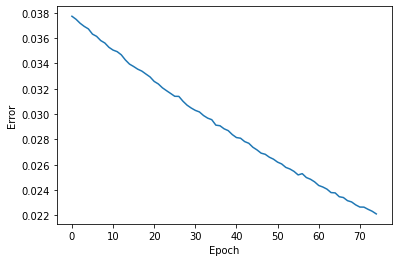

In [59]:
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig("temp.png")
plt.show()